In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import matplotlib
plt.rcParams['svg.fonttype'] = 'none'
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def umapit(mat,com=2,neib=5,dist=0.1,metric='euclidean'):
    reducer = umap.UMAP(
        n_components=com,
        n_neighbors=neib,
        min_dist=dist,
        metric=metric,
        random_state=42,
    )
    embedding = reducer.fit_transform(mat)
    return embedding

def return_mat(fh="20200618_4dbsm_mos_259.csv",
               feat='CONSIDERED_MAF_TISSUE'):
    df = pd.read_csv(fh)
    df = df.loc[
        (df.TISSUE_CELLS == 'tissues') & 
        (df.EXPERIMENT != 'TBR1') &
        ((df.EXPERIMENT.isin(['bulk','subsample'])) | (df.SET_SORT_INCLUDED == True))
    ]
    mat = df.pivot('CHR_POS_REF_ALT','ID',feat)
    mat = mat.fillna(0)
    print(np.shape(mat))
    return mat

class Palette(object):
    def __init__(self):
        self.other='#E8E8E8' # color for "other" category
        
        self.organ = { # colors for organs/lobes; sample-wise
            'prefrontal': '#5C3763',
            'frontal':'#88527B',
            'parietal':'#AF738D',
            'occipital':'#CF9DA4',
            'temporal':'#E8CCC7',
            'cerebellum':'#173E20',
            'heart':'#3D7247',
            'liver':'#679D72',
            'kidneys':'#A0C7A7',
        }
        
        self.marker = {# fans markers
            'neun':'xkcd:brick red', 
            'olig2':'xkcd:orange',
            'lhx2':'xkcd:dark blue',
            'pu1':'xkcd:teal'
        }
        
        self.lateralization = { #lateralization; variant-wise
            'Left_only': '#2472A9',
            'Left_enriched':'#A6CEE3',
            'Right_only':'#EE7C1B',
            'Right_enriched':'#FDBF6F',
            'Both':'#C7C7C7',
            'Not_lateral_bulk':'#919191'
        }
        
        self.clade_fig = { #clade from subsamples; variant-wise
            'I':'b',
            'II':'g',
            'III':'r',
            'IV':'y',
            'V':'xkcd:purple',
            'VI':'xkcd:cyan',
            'VII':'0.8',
            'ZONK':self.other,
        }
        
        self.variant_group = { # variant group
            'All_Variants':'#808080',
            'Brain_and_Organs':'#CCCCCC',
            'Brain_Only':'#0B0E50',
            'Cortex_Only':'#1F4EC3',
            'Brain_Lateralized':'#86BAEC',
            'Brain_Single_Sample': '#D6F8F8'
        }
        
def sample_colors(pal,attr,mat,phen='4dbsm_pheno.tsv'):
    ph = pd.read_csv(phen,sep="\t")
    colr={}
    for p in getattr(pal,attr):
        for x in ph.loc[ph[p]==1]['iid']: colr[x]=getattr(pal,attr)[p]
    for x in mat.index:
        if colr.get(x)==None: colr[x]=pal.other
    return [colr[x] for x in mat.index]

def construct_variant_groups(df):
    groups=[]
    for i ,e in df.iterrows(): 
        group = 'All_Variants'
        if e['SET_IN_BRAIN'] and ~e['SET_BRAIN_ONLY']: group='Brain_and_Organs'
        if e['SET_BRAIN_ONLY']: group='Brain_Only'
        if e['SET_CORTEX_ONLY']: group='Cortex_Only'
        if (e['SET_LEFT_ONLY'] or e['SET_RIGHT_ONLY']) and e['SET_CORTEX_ONLY']: group='Brain_Lateralized'
        if e['SET_ONE_TISSUE'] and e['SET_BRAIN_ONLY']: group='Brain_Single_Sample'
        groups.append(group)
    df['VARIANT_GROUP']=groups
    return df

def variant_colors(pal,attr,mat,phen='20200618_4dbsm_mos_259.csv'):
    ph = pd.read_csv(phen)
    # for variant group colors
    if attr=='variant_group': ph = construct_variant_groups(ph)

    d= dict(zip(ph['CHR_POS_REF_ALT'],ph[attr.upper()]))
    return [getattr(pal,attr)[d[x]] for x in mat.index]

def return_legend(pal,attr,sz=13):
    from matplotlib.lines import Line2D
    legend=[]
    for p in getattr(pal,attr):
        legend.append(
            Line2D([0], [0], marker='o', color='w',
                   label=p.replace('_',' '),markerfacecolor=getattr(pal,attr)[p], markersize=sz)
        )
    return legend

(259, 79)
(79, 259)


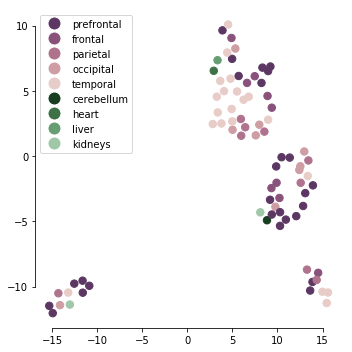

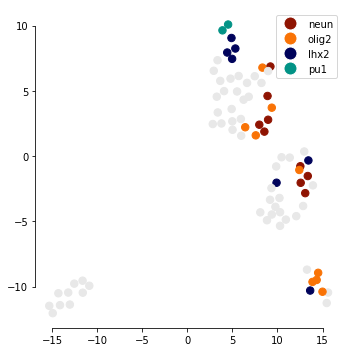

In [3]:
#umap w/ respect to samples
mat = np.transpose(return_mat())
print(np.shape(mat))
neib=3
dist=0.99
emb = umapit(mat=mat,com=2,neib=neib,metric='braycurtis',dist=dist)
pal=Palette()

## color samples by organ/lobe
colr=sample_colors(pal,'organ',mat)
f, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(
    x=emb[:,0],
    y=emb[:,1],
    color=colr,
    s=55,
)
ax.legend(handles=return_legend(pal,'organ'))

sns.despine(ax=ax,trim=0.2)
f.tight_layout()
f.savefig("4dbsm_organ_lobe_umap.svg",dpi=150)
#--------------------------------------------#

## color samples by fans marker
colr=sample_colors(pal,'marker',mat)
f, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(
    x=emb[:,0],
    y=emb[:,1],
    color=colr,
    s=55,
)
ax.legend(handles=return_legend(pal,'marker'))

sns.despine(ax=ax,trim=0.2)
f.tight_layout()
f.savefig("4dbsm_fans_marker_umap.svg",dpi=150)
#--------------------------------------------#


(259, 79)


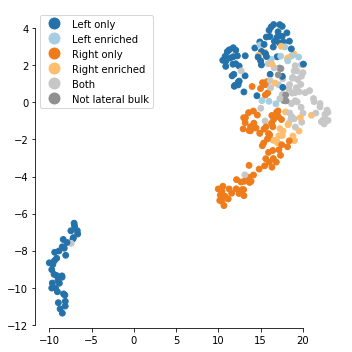

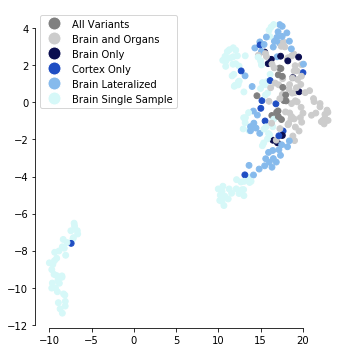

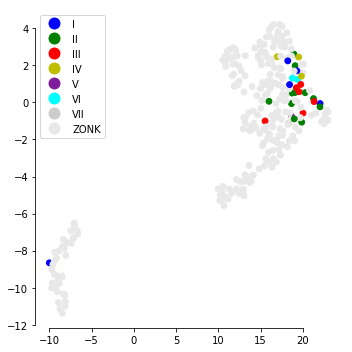

In [4]:
# umap w/ respect to variants
mat =return_mat()
neib=20
dist=0.8
emb = umapit(mat=mat,com=2,neib=neib,metric='braycurtis',dist=dist)
pal=Palette()

## color variants by lateralization
colr=variant_colors(pal,'lateralization',mat)
f, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(
    x=emb[:,0],
    y=emb[:,1],
    color=colr,
    s=34,
)
ax.legend(handles=return_legend(pal,'lateralization'))

sns.despine(ax=ax,trim=0.2)
f.tight_layout()
f.savefig("4dbsm_lateralization_umap.svg",dpi=150)
#--------------------------------------------#
## color variants by variant groups
colr=variant_colors(pal,'variant_group',mat)
f, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(
    x=emb[:,0],
    y=emb[:,1],
    color=colr,
    s=34,
)
ax.legend(handles=return_legend(pal,'variant_group'))

sns.despine(ax=ax,trim=0.2)
f.tight_layout()
f.savefig("4dbsm_variant_group_umap.svg",dpi=150)
#--------------------------------------------#

## color variants by clades
colr=variant_colors(pal,'clade_fig',mat)
f, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(
    x=emb[:,0],
    y=emb[:,1],
    color=colr,
    s=34,
)
ax.legend(handles=return_legend(pal,'clade_fig'))

sns.despine(ax=ax,trim=0.2)
f.tight_layout()
f.savefig("4dbsm_clade_umap.svg",dpi=150)
#--------------------------------------------#